A NN is previously trained on all categories (There is only TRA_start and not TRA_end category). The accuracy is 97.8%. Then we take this network and perform testing including a realistic size of NoSvs (1:160)

In [42]:
# only one category for translocations

## Load dependences and setting output configuration

In [43]:
import numpy as np
from keras.utils.np_utils import to_categorical
import keras
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load labels from npy files

In [44]:
datapath = "F:/1_GTCG/data/081018/TrainingData_081018/"
sv_types = ["DUP","INDEL", "INV", "TRA"]
window_size = 50

def loadSVData(sv_types, datapath):
    G1_data = {}
    G1_labels ={}
    for sv_type in sv_types:
        if sv_type != 'TRA':
            G1_data[sv_type] =np.load(datapath +  "/" + sv_type + '/G1/ChannelData/G1.npy')
            G1_labels[sv_type] = np.load(datapath +  "/" + sv_type + '/G1/LabelData/G1_17_label.npy') 
        else:
            G1_data[sv_type] =np.load(datapath +  "/" + sv_type + '/G1/ChannelData/G1.npy')
            G1_labels[sv_type] = np.load(datapath +  "/" + sv_type + '/G1/LabelData/G1_12_label.npy') 
        print(sv_type + ':' + str(G1_data[sv_type].shape))
        print(G1_data[sv_type][0])
    return G1_data, G1_labels    

In [45]:
def loadNoSVData(datapath):
    N1_data = np.empty([0, 38, window_size])
    N1_labels = []
    for sv_type in sv_types:
        N1_data_new=np.load(datapath +  "/" + sv_type  + '/N1/ChannelData/17_channel_maker_real_germline.npy')
        N1_labels_new = np.load(datapath +  "/" + sv_type + '/N1/LabelData/N1_17_label.npy')         
        N1_data = np.concatenate((N1_data, N1_data_new))
        N1_labels = np.concatenate((N1_labels, N1_labels_new))
        print("NoSV" + ':' + str(N1_data.shape))
        #print(N1_data[0])
    return N1_data, N1_labels

In [46]:
G1_data, G1_labels = loadSVData(sv_types, datapath)

DUP:(9636, 38, 50)
[[ 49.  48.  50. ...,  74.  80.  79.]
 [  0.   0.   0. ...,   0.   0.   0.]
 [  0.   0.   0. ...,   0.   0.   0.]
 ..., 
 [ 20.  20.  20. ...,  60.  60.  60.]
 [  1.   1.   1. ...,   1.   1.   1.]
 [  0.   0.   0. ...,   0.   0.   0.]]
INDEL:(19417, 38, 50)
[[ 51.  55.  50. ...,  28.  27.  27.]
 [  0.   0.   0. ...,   0.   0.   0.]
 [  0.   0.   0. ...,   0.   0.   0.]
 ..., 
 [ 60.  60.  40. ...,  20.  20.  20.]
 [  1.   1.   1. ...,   1.   1.   1.]
 [  0.   0.   0. ...,   0.   0.   0.]]
INV:(38502, 38, 50)
[[ 36.  38.  39. ...,  45.  46.  43.]
 [  0.   0.   0. ...,   0.   0.   0.]
 [  0.   0.   0. ...,   0.   0.   0.]
 ..., 
 [ 40.  40.  40. ...,  20.  20.  20.]
 [  1.   1.   1. ...,   1.   1.   1.]
 [  0.   0.   0. ...,   0.   0.   0.]]
TRA:(72480, 38, 50)
[[ 41.  42.  41. ...,  40.  40.  38.]
 [  0.   0.   0. ...,   0.   0.   0.]
 [  0.   0.   0. ...,   0.   0.   0.]
 ..., 
 [ 60.  60.  60. ...,  80.  80.  40.]
 [  1.   1.   1. ...,   1.   1.   1.]
 [  0.   0.   

In [47]:
N1_data, N1_labels = loadNoSVData(datapath)

NoSV:(19960, 38, 50)
NoSV:(40044, 38, 50)
NoSV:(60004, 38, 50)
NoSV:(170284, 38, 50)


### Find  the indexes that split the categories

In [48]:
def find_splitting_indices(labels):
    for i in range (0, labels.shape[0] - 1):
        if (labels[i] != labels[i+1]):
            print(i , ': ', labels[i] , labels[i+1] )        

In [49]:
find_splitting_indices(G1_labels["DUP"])

4820 :  DUP_start DUP_end


In [50]:
find_splitting_indices(G1_labels["INDEL"])

4697 :  DEL_start DEL_end
9377 :  DEL_end INS_pos


In [51]:
find_splitting_indices(G1_labels["INV"])

19242 :  INV_start INV_end


In [52]:
find_splitting_indices(G1_labels["TRA"])

36222 :  TRA_start TRA_end


In [53]:
class_size = 4680
X_DUP_start =  G1_data["DUP"][0:class_size]
X_DUP_end =  G1_data["DUP"][4821:4821+class_size]
X_DEL_start = G1_data["INDEL"][0: class_size]
X_DEL_end = G1_data["INDEL"][4698: 4698+ class_size]
X_INS_pos = G1_data["INDEL"][9378: 9378+ class_size]
X_INV_start = G1_data["INV"][0: class_size]
X_INV_end = G1_data["INV"][19243: 19243 + class_size]
X_TRA_start = G1_data["TRA"][0: class_size]
#X_TRA_end = G1_data["TRA"][36223:36223+ class_size]

In [54]:

y_DUP_start =  G1_labels["DUP"][0:class_size]
y_DUP_end =  G1_labels["DUP"][4821:4821+class_size]
y_DEL_start = G1_labels["INDEL"][0: class_size]
y_DEL_end = G1_labels["INDEL"][4698: 4698+ class_size]
y_INS_pos = G1_labels["INDEL"][9378: 9378+ class_size]
y_INV_start = G1_labels["INV"][0: class_size]
y_INV_end = G1_labels["INV"][19243: 19243 + class_size]
y_TRA_start = G1_labels["TRA"][0: class_size]
#y_TRA_end = G1_labels["TRA"][36223:36223+ class_size]

## Split into training, validation and test labelssets

In [55]:
def ConcatAllCategories(start, end):    
    X= np.concatenate((X_DUP_start[start:end], X_DUP_end[start:end], X_DEL_start[start:end], X_DEL_end[start:end], X_INS_pos[start:end],X_INV_start[start:end], X_INV_end[start:end], X_TRA_start[start:end],  N1_data[start:end]   ))
    y= np.concatenate((y_DUP_start[start:end], y_DUP_end[start:end], y_DEL_start[start:end], y_DEL_end[start:end], y_INS_pos[start:end],y_INV_start[start:end], y_INV_end[start:end], y_TRA_start[start:end],  N1_labels[start:end]   ))
    return X, y

In [56]:
X_train, y_train = ConcatAllCategories(0, int(2*class_size/3))
X_val, y_val =     ConcatAllCategories(int(2*class_size/3), int(5*class_size/6) )
X_test, y_test =   ConcatAllCategories(int(5*class_size/6), class_size )

In [57]:
X_test = np.concatenate((X_test, N1_data[class_size:]))
y_test = np.concatenate((y_test, N1_labels[class_size:]))

In [58]:
G1_data = []
N1_data = []

In [59]:
G1_labels = []
N1_labels = []

### Number of training, validation and test windows

In [60]:
X_train.shape

(28080, 38, 50)

In [61]:
X_val.shape

(7020, 38, 50)

In [62]:
X_test.shape

(172624, 38, 50)

In [63]:
y_test.shape

(172624,)

In [64]:
number_channels = X_train.shape[1]
number_channels

38

## Normalize labels using the reads coverage as parameter

In [65]:
coverage = np.median(X_train[:, 0, :]) #the median of the coverage in the normal cells
coverage


43.0

In [66]:
def normalize(X):       
    for i in range (0, len(X)):                              
        for j in range(0,number_channels):                                                                                            
            X[i][j] = np.divide(X[i][j], coverage)*100 
normalize(X_train)
normalize(X_val)
normalize(X_test)


In [67]:
def eliminate_noise_chanels(X):
    #return np.delete(X, [8-1,9-1,10-1,11-1, 12-1,13-1, 14-1, 15-1,16-1, 17-1,18-1,19-1,21-1, 22-1, 23-1,24-1, 27,28,29,30,31,32], axis=1)
    return np.take(X, [0,1,2,3,4,5,6, 7,8, 27,28], axis = 1)

In [68]:
X_train = eliminate_noise_chanels(X_train)
X_val = eliminate_noise_chanels(X_val)
X_test = eliminate_noise_chanels(X_test)

In [69]:
X_train.shape

(28080, 11, 50)

In [70]:
number_channels = X_train.shape[1]
number_channels

11

## Plots several  windows from the somatic SV category

In [71]:
n_windows = 30
label = ["None"] * number_channels

In [89]:
label[0] = ":coverage"
label[1] = "#left clipped reads"
label[2] = "#right clipped reads"
label[3] = "INV1"
label[4] = "INV2"
label[5] = "DUP1"
label[6] = "DUP2"
label[7] = "TRA1"
label[8] = "TRA2"
label[9] = "#split reads right split"
label[10] = "#split reads left split"

In [72]:
from numpy import *
import math
import matplotlib.pyplot as plt

colors =['b','g', 'm', 'gray', 'r','c', 'darkgreen' ,'y', 'k', 'orange', 'gray']

def plot_channels(start_window, n_windows):
    for i in range (start_window, start_window + n_windows, 5):
        print(y_train[i], 'id:', i)
        print('id:', i)
        for j in range (0, number_channels):   
            shift = 0
            start =0
            if j in [0,11]:
                shift = -100
            if j > 8:
                start = -60
            Z = [start + shift + 300 + x - 5*j*4 for x in X_train[i][j]]  
            #plt.ylim([100,700])
            if np.max(Z) > 1000:
                plt.ylim([-200,1000])
                Z = [start + shift + 300 + x - 5*j*4 - 400 for x in X_train[i][j]]  
            if j>8:
                plt.plot(Z,  label = label[j], linestyle=':', linewidth=1.5, color = colors[j % 9])
            else:
                plt.plot(Z, label = label[j], color = colors[j])
        
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 10})    
        plt.show()

5 id: 0
id: 0


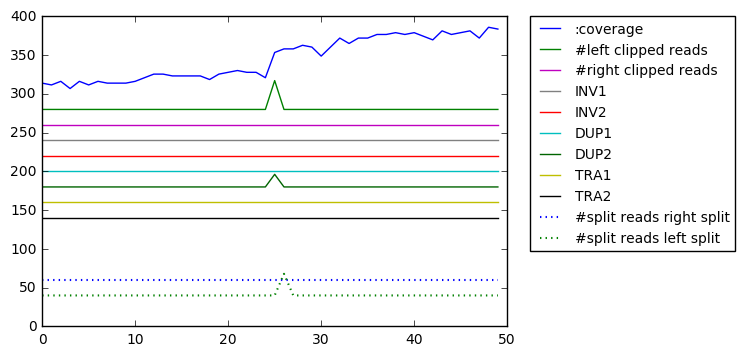

5 id: 5
id: 5


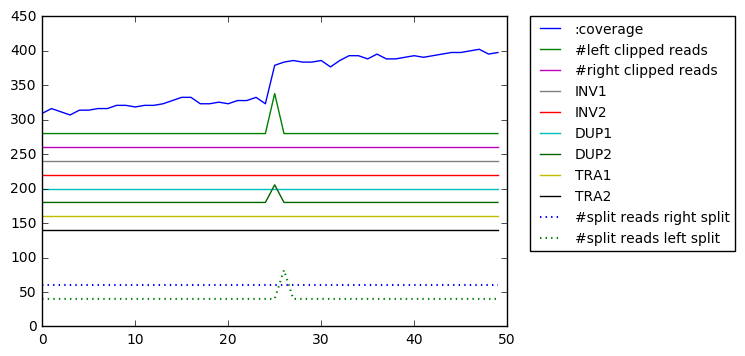

5 id: 10
id: 10


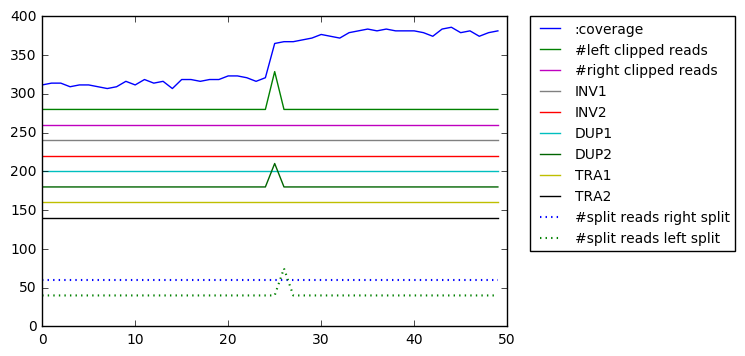

5 id: 15
id: 15


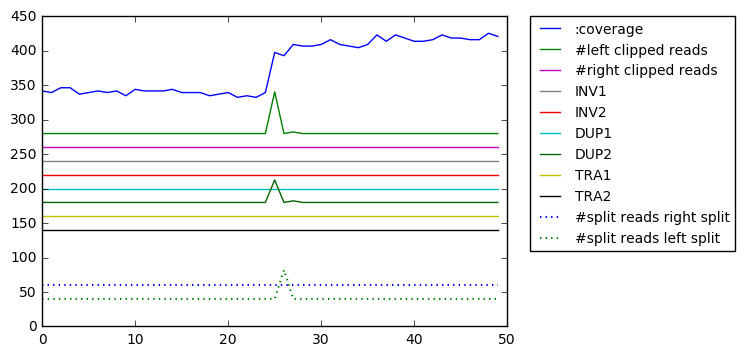

5 id: 20
id: 20


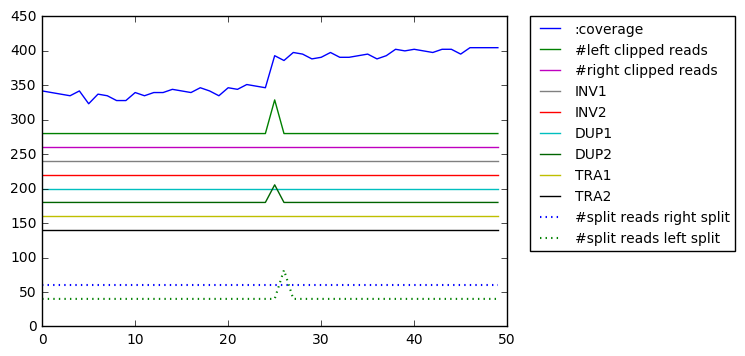

5 id: 25
id: 25


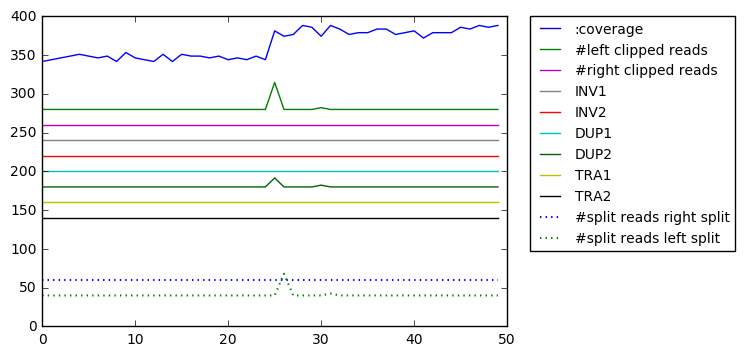

In [91]:
start_window = 0
plot_channels(start_window, n_windows)

5 id: 3000
id: 3000


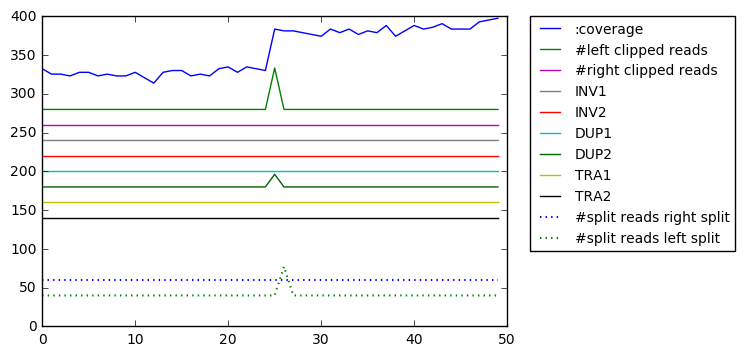

5 id: 3005
id: 3005


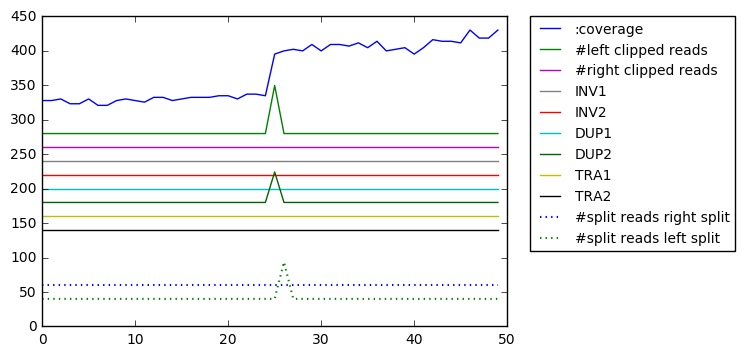

5 id: 3010
id: 3010


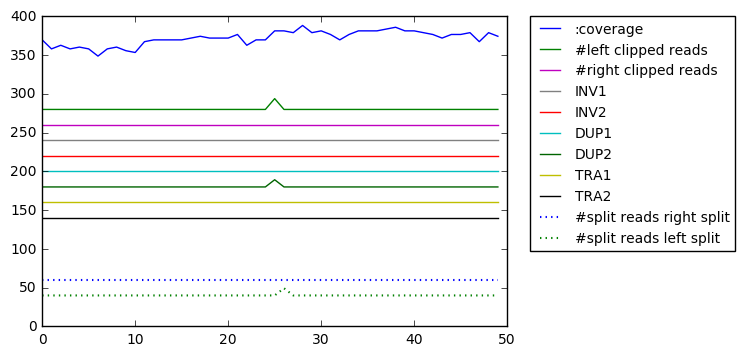

5 id: 3015
id: 3015


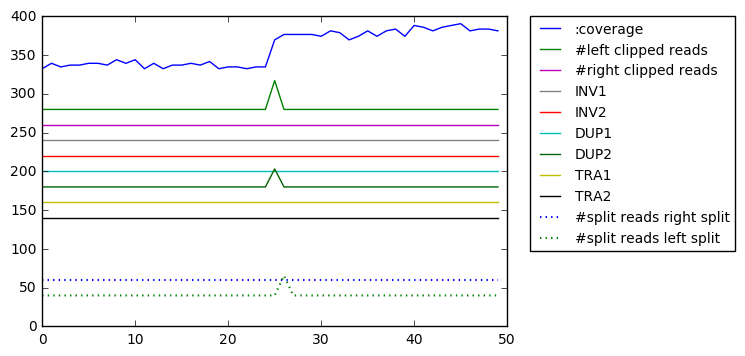

5 id: 3020
id: 3020


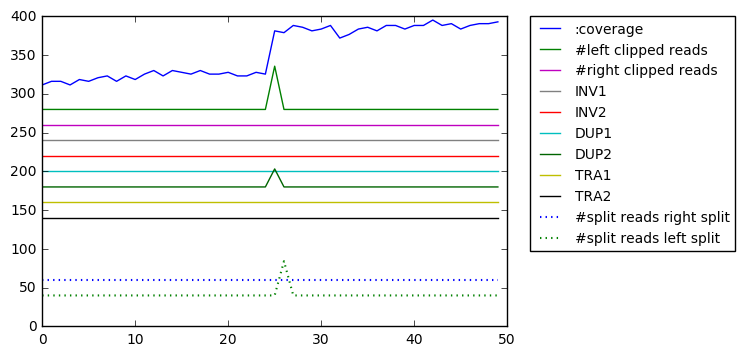

5 id: 3025
id: 3025


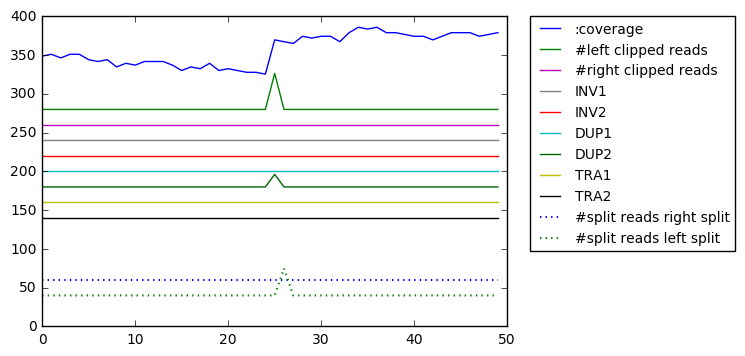

In [92]:
start_window =3000
plot_channels(start_window, n_windows)

DUP_end id: 6000
id: 6000


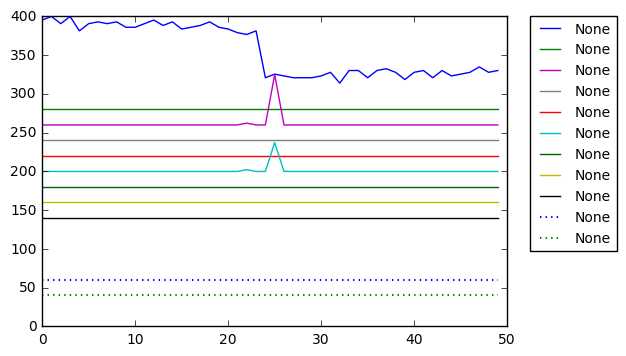

DUP_end id: 6005
id: 6005


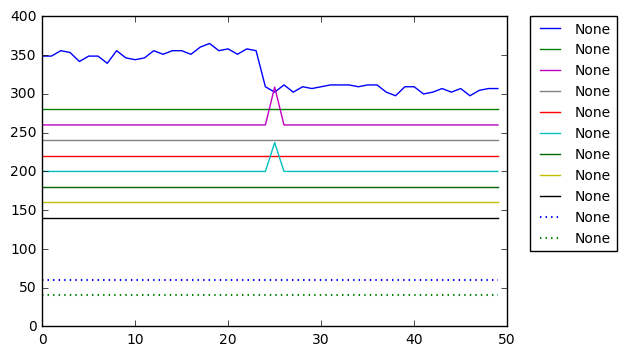

DUP_end id: 6010
id: 6010


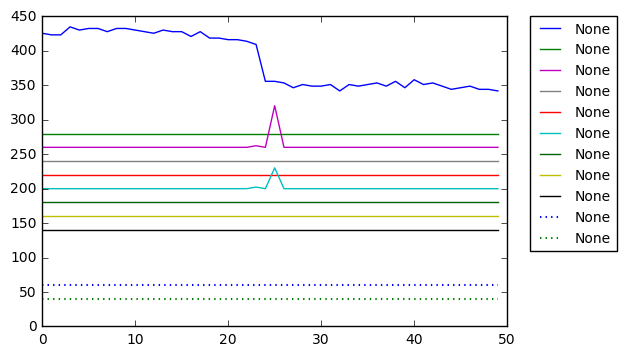

DUP_end id: 6015
id: 6015


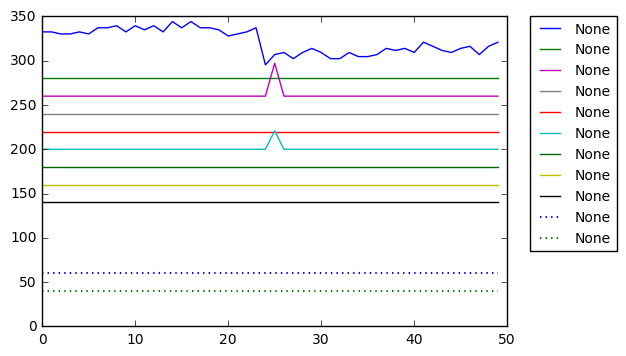

DUP_end id: 6020
id: 6020


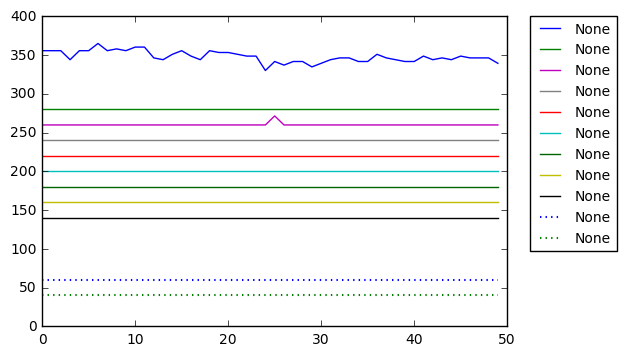

DUP_end id: 6025
id: 6025


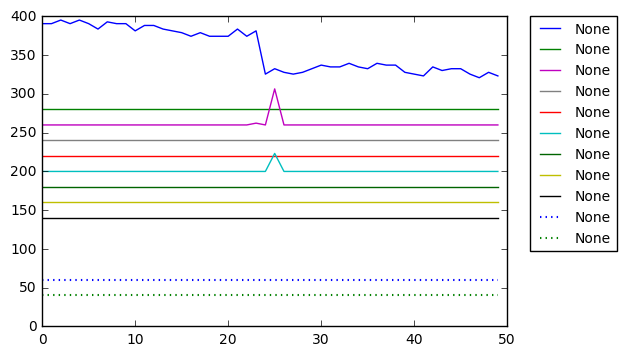

In [75]:
start_window =6000
plot_channels(start_window, n_windows)

   
## Transposes every window in X, to comply to McFly format

In [90]:
def transposelabelsset(X):
    image = []
    for i in range (0, len(X -1)):
        tr = X[i].transpose()
        image.append(tr)
    return np.array(image)

image1 = transposelabelsset(X_train)
image2 = transposelabelsset(X_val)
image3 = transposelabelsset(X_test)
X_train = image1
X_val = image2
X_test = image3

n_channels = len(X_train[0][0])
print(len(X_test[0][0]))

50


## Prepare the labels in McFly format

In [77]:
classlabels = list(set(y_train))
mapclasses = {'DUP_end': 0, 'DUP_start': 5, 'INV_end': 1, 'TRA_start': 2, 'INS_pos': 3, 'DEL_start': 6, 'noSV': 4, 'INV_start': 7, 'DEL_end': 8}
print(mapclasses)

y_train = np.array([mapclasses[c] for c in y_train], dtype='int')
y_val = np.array([mapclasses[c] for c in y_val], dtype='int')
y_test = np.array([mapclasses[c] for c in y_test], dtype='int')
y_train_binary = to_categorical(y_train)
y_val_binary = to_categorical(y_val)
y_test_binary = to_categorical(y_test)

{'DEL_start': 6, 'DEL_end': 8, 'TRA_start': 2, 'DUP_start': 5, 'DUP_end': 0, 'INV_end': 1, 'INS_pos': 3, 'noSV': 4, 'INV_start': 7}


In [78]:
y_test_binary

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [79]:
y_val_binary


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [80]:
X_train.shape

(28080, 50, 11)

## Generate neural networks architectures

In [40]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, MaxPooling1D
from keras.optimizers import Adam
import sys
import os
import numpy as np
sys.path.insert(0, os.path.abspath('..'))
from mcfly import modelgen, find_architecture

In [41]:
np.random.seed = 321
num_classes = y_train_binary.shape[1]

In [64]:
%%time
models = modelgen.generate_models(X_train.shape,
                                  num_classes,
                                  number_of_models = 4,
                                  model_type = 'CNN',
                                  cnn_min_layers=1,
                                  cnn_max_layers=1,
                                  cnn_min_filters = 20, 
                                  cnn_max_filters = 20, 
                                  cnn_min_fc_nodes=4, 
                                  cnn_max_fc_nodes=10,
                                  low_lr=1.2, high_lr=2,
                                  kernel_size = 7)

Wall time: 3.69 s


In [65]:
%%time
for model, params, model_types in models:
    print(params)
    model.summary()

{'kernel_size': 7, 'fc_hidden_nodes': 7, 'learning_rate': 0.018943568049681756, 'filters': array([20]), 'regularization_rate': 0.09288402824211824}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_25 (Batc (None, 50, 11)            44        
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 50, 20)            1560      
_________________________________________________________________
batch_normalization_26 (Batc (None, 50, 20)            80        
_________________________________________________________________
activation_25 (Activation)   (None, 50, 20)            0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 7)                 7007 

## Train the networks

In [66]:
train_set_size = X_train.shape[0]
train_set_size

28080

## Plot training process

Currently run with a very low number of epochs

## Take the best current model 

In [70]:
best_model_index = np.argmax(val_accuracies)

In [71]:
best_model, best_params, best_model_types = models[best_model_index]
print(best_model_index, best_model_types, best_params)

1 CNN {'kernel_size': 7, 'fc_hidden_nodes': 9, 'learning_rate': 0.02721502111440259, 'filters': array([20]), 'regularization_rate': 0.009318741994633048}


## Save the best current model

In [76]:
from keras.models import load_model

model_path = os.path.join('F:/CNN/notebooks/', 'Gtcg_291018_all_cats_ver2_good_')

best_model.save(model_path)

In [75]:
#We make a copy of the model, to start training from fresh
nr_epochs = 1
datasize = train_set_size # Change in `X_train.shape[0]` if training complete data set
history = best_model.fit(X_train[:datasize,:,:], y_train_binary[:datasize,:],
              epochs=nr_epochs, validation_data=(X_val, y_val_binary))

Train on 28080 samples, validate on 7020 samples
Epoch 1/1
28080/28080 [==============================] - 11s 381us/step - loss: 0.2869 - acc: 0.9676 - val_loss: 0.2696 - val_acc: 0.9818


## Reload the best current model

In [81]:
import os
from keras.models import load_model
model_path = os.path.join('F:/CNN/notebooks/', 'Gtcg_291018_all_cats_ver2_good')
model_reloaded = load_model(model_path)

## Inspect model predictions on test labels

In [82]:
model = model_reloaded
labelssize = X_test.shape[0]
probs = model.predict_proba(X_test[:labelssize,:,:],batch_size=1)

## Columns are predicted, rows are truth

In [83]:
dict=mapclasses
dict_sorted = sorted(dict.items(), key=lambda x: x[1])
dict_sorted

[('DUP_end', 0),
 ('INV_end', 1),
 ('TRA_start', 2),
 ('INS_pos', 3),
 ('noSV', 4),
 ('DUP_start', 5),
 ('DEL_start', 6),
 ('INV_start', 7),
 ('DEL_end', 8)]

In [84]:
labels = [i[0] for i in dict_sorted]

In [85]:
import pandas as pd
predicted = probs.argmax(axis=1)
y_index = y_test_binary.argmax(axis=1)
confusion_matrix = pd.crosstab(pd.Series(y_index), pd.Series(predicted))
confusion_matrix.index = [labels[i] for i in confusion_matrix.index]
confusion_matrix.columns = [labels[i] for i in confusion_matrix.columns]
confusion_matrix.reindex(columns=[l for l in labels], fill_value=0)
confusion_matrix

,DUP_end,INV_end,TRA_start,INS_pos,noSV,DUP_start,DEL_start,INV_start,DEL_end
DUP_end,769,0,2,0,0,2,6,0,1
INV_end,1,743,1,2,0,4,4,25,0
TRA_start,3,0,758,8,0,6,0,2,3
INS_pos,0,0,16,743,0,0,13,1,7
noSV,0,0,0,0,166376,8,0,0,0
DUP_start,1,0,5,0,0,773,0,0,1
DEL_start,0,0,1,0,2,0,777,0,0
INV_start,0,1,1,1,0,17,3,757,0
DEL_end,0,1,4,0,0,9,0,0,766


## Test best current model on testset

### Overall accuracy on the test set:

In [86]:
%%time
score_test = model_reloaded.evaluate(X_test, y_test_binary, verbose=False)
print('Test loss and accuracy of best model: ' + str(score_test))

Test loss and accuracy of best model: [0.20805352612458386, 0.99906154416535364]
Wall time: 22.6 s


### Re-check the train and validation scores: 

In [ ]:
score_train = model_reloaded.evaluate(X_train, y_train_binary, verbose=False)
print('Train Score of best model: ' + str(score_train))

In [ ]:
score_val = model_reloaded.evaluate(X_val, y_val_binary, verbose=False)
print('Val Score of best model: ' + str(score_val))